# Customer Purchase Behavior Clustering
- This notebook performs clustering on customer purchase behavior data to identify distinct purchase patterns.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [8]:

purchase_behavior_features = [
    'NumDealsPurchases',  # Promo purchases
    'NumWebPurchases',  # Online
    'NumCatalogPurchases',  # Catalog
    'NumStorePurchases',  # In-store
    'NumWebVisitsMonth'  # Website visits (optional: inverse indicator)
]

df = pd.read_csv('featured_customer_segmentation.csv')

[11200.0, 7108.305266541398, 5115.744405090915, 4450.509295655653, 4040.849038181331, 3698.8451964638557, 3458.127792871868, 3234.7999986911213, 3015.843537850562]


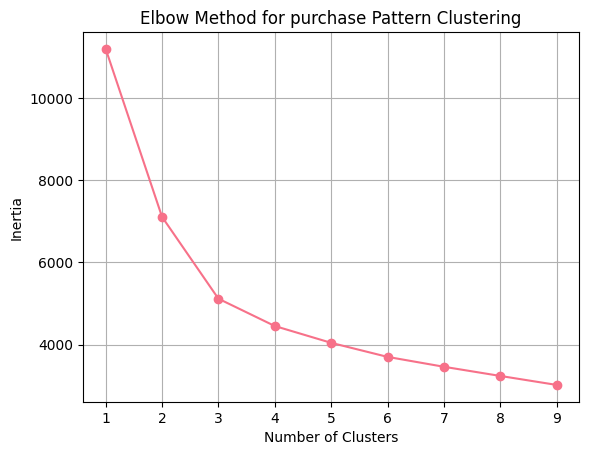

In [9]:
scaler = StandardScaler()
X_behavior = scaler.fit_transform(df[purchase_behavior_features])

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_behavior)
    inertia.append(kmeans.inertia_)

print(inertia)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for purchase Pattern Clustering')
plt.grid(True)
plt.show()


                 NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
PurchaseCluster                                                            
0                             1.84             1.99                 0.54   
1                             4.15             6.63                 2.72   
2                             1.31             5.03                 5.47   

                 NumStorePurchases  NumWebVisitsMonth  Total_Purchases  
PurchaseCluster                                                         
0                             3.16               6.40             5.68  
1                             7.28               6.56            16.64  
2                             8.36               2.82            18.86  


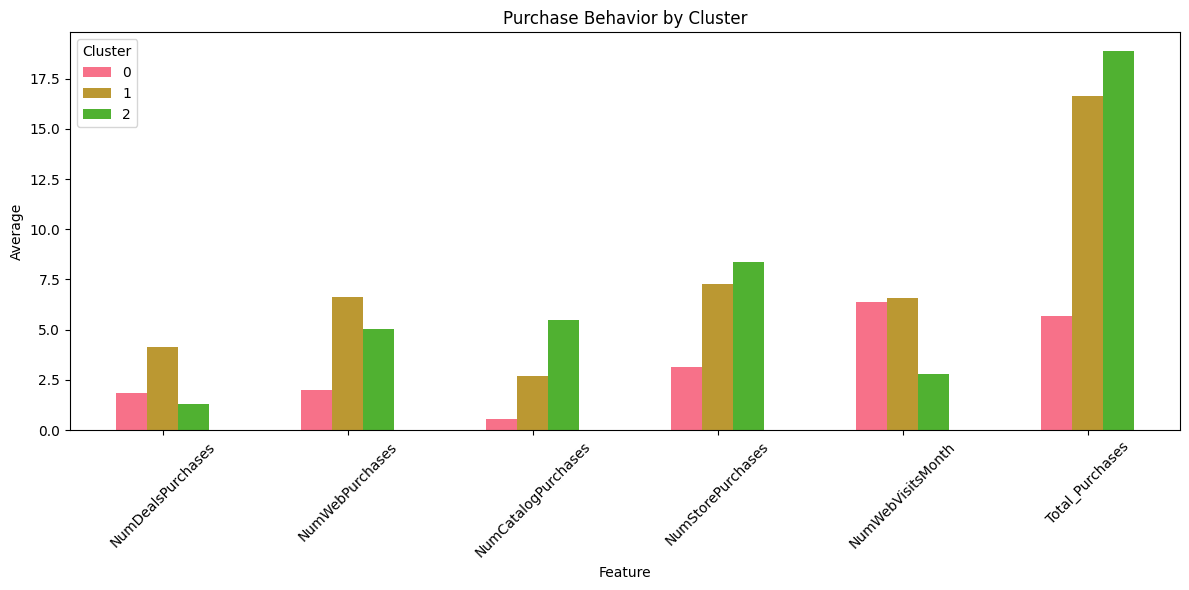

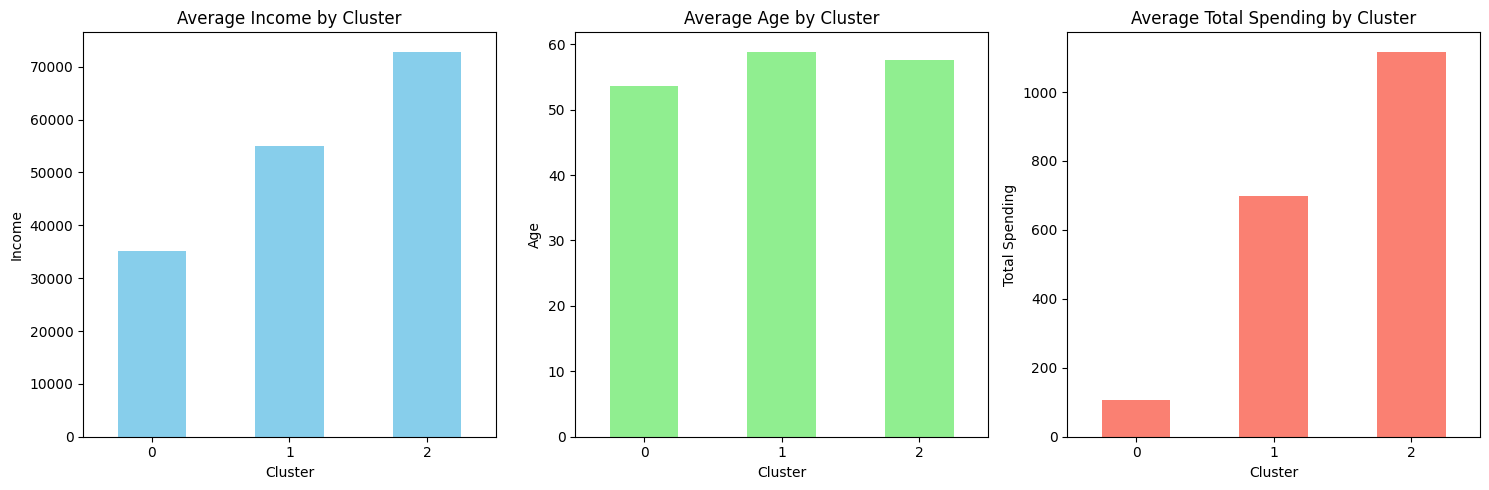

In [10]:

kmeans = KMeans(n_clusters=3, random_state=42)
df['PurchaseCluster'] = kmeans.fit_predict(X_behavior)
purchase_behavior_features = list(purchase_behavior_features) + ['Total_Purchases']
cluster_summary = df.groupby('PurchaseCluster')[purchase_behavior_features].mean().round(2)
print(cluster_summary)

cluster_summary.T.plot(kind='bar', figsize=(12, 6))
plt.title('Purchase Behavior by Cluster')
plt.ylabel('Average')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Create separate small charts for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Income
df.groupby('PurchaseCluster')['Income'].mean().round(2).plot(
    kind='bar', ax=axes[0], color='skyblue'
)
axes[0].set_title('Average Income by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Income')
axes[0].tick_params(rotation=0)

# Plot Age 
df.groupby('PurchaseCluster')['Age'].mean().round(2).plot(
    kind='bar', ax=axes[1], color='lightgreen'
)
axes[1].set_title('Average Age by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Age')
axes[1].tick_params(rotation=0)

# Plot Total Spending
df.groupby('PurchaseCluster')['Total_Spending'].mean().round(2).plot(
    kind='bar', ax=axes[2], color='salmon'
)
axes[2].set_title('Average Total Spending by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Total Spending')
axes[2].tick_params(rotation=0)

plt.tight_layout()
plt.show()

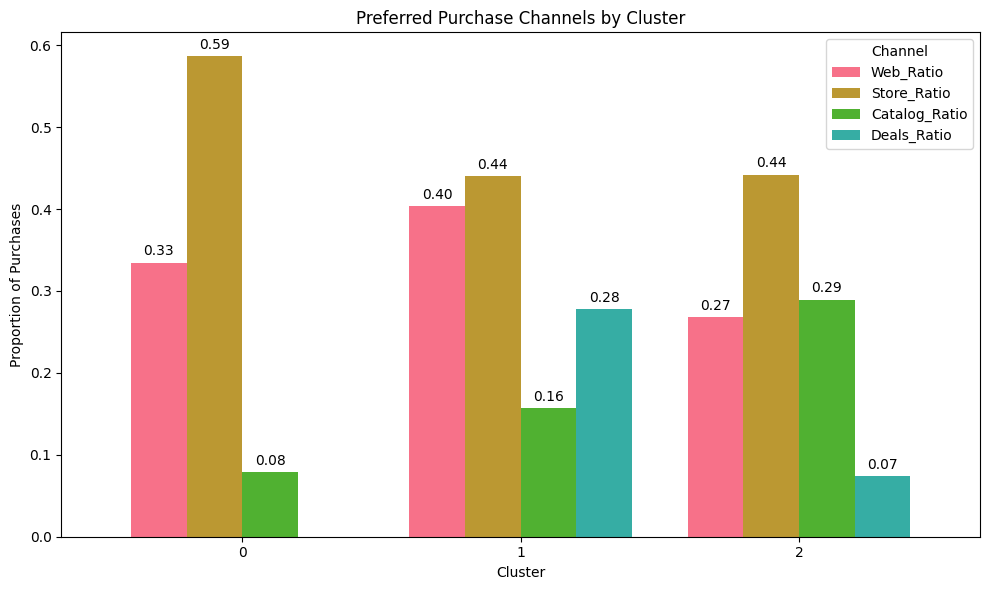

Cluster 0 favorite channel: Deals (inf%)
Cluster 1 favorite channel: Store (43.99%)
Cluster 2 favorite channel: Store (44.20%)


In [11]:

# Calculate proportion of each purchase channel by cluster
df['Total_Purchases'] = df['NumWebPurchases'] + df['NumStorePurchases'] + df['NumCatalogPurchases'] + df[
    'NumDealsPurchases']

# Get average ratios per cluster
channel_ratios = df.groupby('PurchaseCluster')[['Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio']].mean()

# Create bar plot
ax = channel_ratios.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Preferred Purchase Channels by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Purchases')
plt.legend(title='Channel')
plt.xticks(rotation=0)

# Add value labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# Print favorite channel for each cluster
for cluster in range(len(channel_ratios)):
    favorite_channel = channel_ratios.iloc[cluster].idxmax()
    ratio = channel_ratios.iloc[cluster][favorite_channel]
    print(f"Cluster {cluster} favorite channel: {favorite_channel.replace('_Ratio', '')} ({ratio:.2%})")


🛒 SCATTER PLOT ANALYSIS FOR PURCHASE BEHAVIOR CLUSTERS

1. PCA-based Scatter Plot for Purchase Cluster Visualization


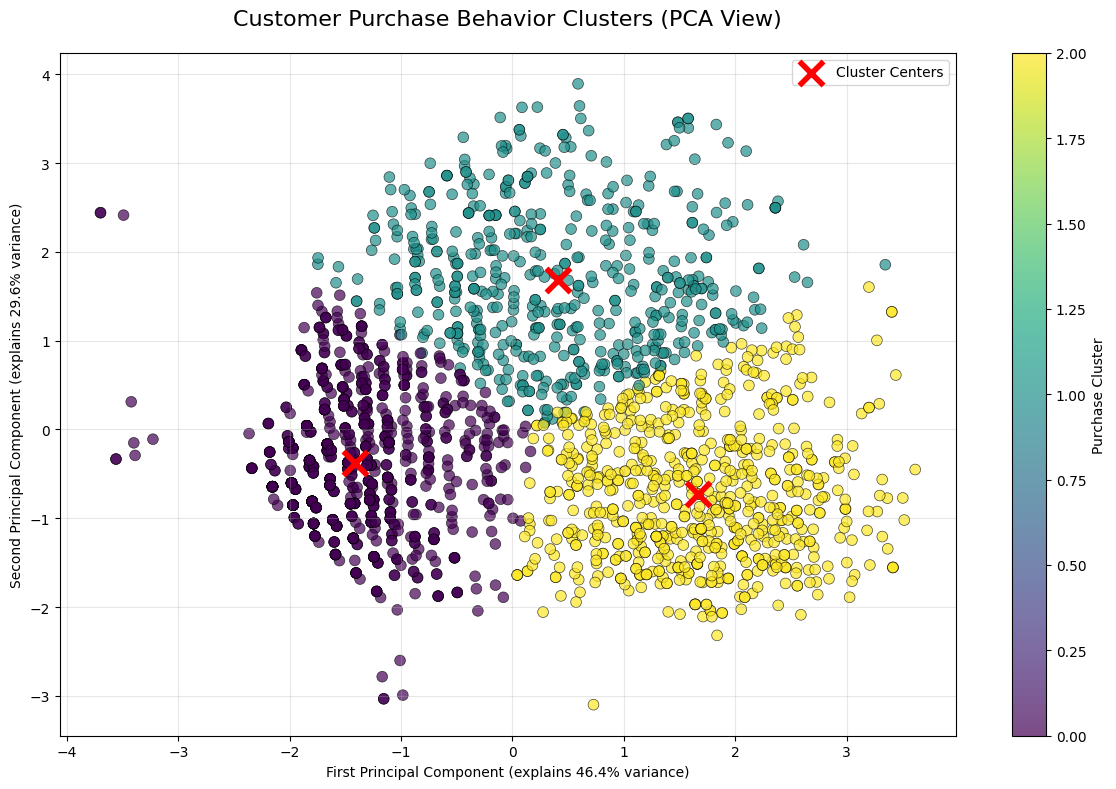

PCA explains 76.1% of total variance in purchase behavior


In [12]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("🛒 SCATTER PLOT ANALYSIS FOR PURCHASE BEHAVIOR CLUSTERS")
print("="*65)

# 1. PCA Scatter Plot - Most comprehensive view of purchase patterns
print("\n1. PCA-based Scatter Plot for Purchase Cluster Visualization")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_behavior)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['PurchaseCluster'], 
                     cmap='viridis', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Purchase Cluster')
plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Purchase Behavior Clusters (PCA View)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', 
           s=300, linewidths=4, label='Cluster Centers')
plt.legend()
plt.tight_layout()
plt.show()

print(f"PCA explains {sum(pca.explained_variance_ratio_):.1%} of total variance in purchase behavior")
